# Predicting Procurement Compliance Using KPI-Driven Machine Learning Models
**Author:** Brittany Dowdle

**Date:** 7/21/2025

**Objective:** This notebook is part of the overall capstone project. The ultimate goal is to identify patterns and predictors of non-compliant suppliers using machine learning techniques.

### Introduction
This project uses the [Procurement KPI Analysis Dataset](https://www.kaggle.com/datasets/shahriarkabir/procurement-kpi-analysis-dataset) to predict compliance of suppliers. The dataset includes purchase order records from 5 different suppliers from 2022-2023. Using the cleaned data set prepared in [cleaning.ipynb](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone/blob/main/Notebooks/cleaning.ipynb) and explored in [EDA.ipynb](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone/blob/main/Notebooks/EDA.ipynb), this notebook focuses on building and evaluating the machine learning model. 

****
### Imports
In the code cell below are the necessary Python libraries for this notebook. *All imports should be at the top of the notebook.*

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.utils import estimator_html_repr
from IPython.display import display, HTML

from sklearn.utils.class_weight import compute_sample_weight

****
### 1. Load the Cleaned Dataset

In [2]:
# Load the dataset
df = pd.read_csv("C:/Users/Britt/Documents/44688/Dowdle_Analytics_Capstone/Data/cleaned_procurement_data.csv")

# Convert target variable to numeric
df['compliance'] = df['compliance'].map({'Yes': 1, 'No': 0})

print(df['compliance'].value_counts())

compliance
1    623
0    135
Name: count, dtype: int64


### 2. Define Features and Targets

In [3]:
# Define column groups (using all features)
categorical_cols = ['supplier', 'item_category', 'order_status']
numeric_cols = ['quantity', 'unit_price', 'negotiated_price', 'defective_units', 'price_diff', 'defect_rate', 'lead_time_days']

# Define preprocessing for each column type
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine into full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### 3. Split the Dataset

In [4]:
# Split the data (Stratified)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df[categorical_cols + numeric_cols], df['compliance']):
    X_train = df.iloc[train_idx][categorical_cols + numeric_cols]
    y_train = df.iloc[train_idx]['compliance']
    X_test = df.iloc[test_idx][categorical_cols + numeric_cols]
    y_test = df.iloc[test_idx]['compliance']  

# Show row counts
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])  

Training set size: 606
Test set size: 152


### 4. Train a Logistic Regression Model

In [5]:
# Set output for notebook
set_config(display='diagram')

# Logistic Regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
logreg_pipeline.fit(X_train, y_train)

# Display diagram
html = estimator_html_repr(logreg_pipeline)
display(HTML(html))

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 5. Train a Random Forest Model

In [6]:
# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
# Set parameters
rf_params = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [4]
}
# Hyperparameter tuning
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

### 6. Evaluate the Models

In [7]:
# Compare model metrics
print("\n=== Logistic Regression Classification Report ===")
y_pred_lr = logreg_pipeline.predict(X_test)
print(classification_report(y_test, y_pred_lr, zero_division=0))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, logreg_pipeline.predict_proba(X_test)[:, 1]))

print("=== Random Forest Classification Report ===")
y_pred_rf = rf_best.predict(X_test)
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("Random Forest ROC AUC:", roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]))


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.82      1.00      0.90       125

    accuracy                           0.82       152
   macro avg       0.41      0.50      0.45       152
weighted avg       0.68      0.82      0.74       152

Logistic Regression ROC AUC: 0.7182222222222223
=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.82      0.98      0.89       125

    accuracy                           0.81       152
   macro avg       0.41      0.49      0.45       152
weighted avg       0.67      0.81      0.74       152

Random Forest ROC AUC: 0.7407407407407407


Both the Logistic Regression and Random Forest models achieved high overall accuracy (82% and 81%, respectively), but that is only due to predicting class 1 accurately. Both models fail to predict class 0 altogether — with precision, recall, and F1-score all equal to 0.00 for that class. This is a serious concern if detecting non-compliance is important, as the models are essentially "blind" to it.

### 7. Visualize the Confusion Matrix

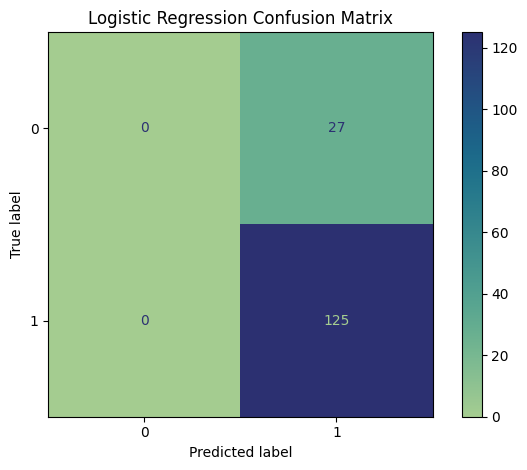

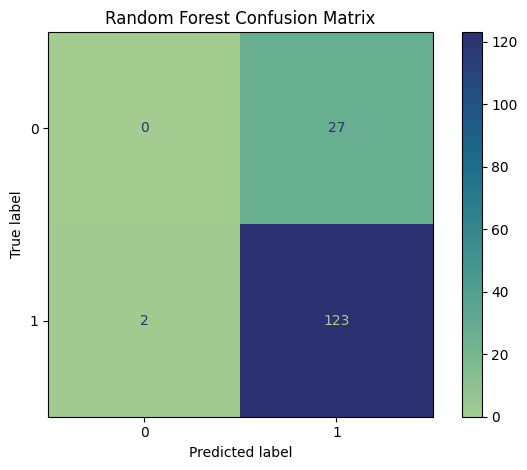

In [8]:
# Logistic Regression
ConfusionMatrixDisplay.from_estimator(logreg_pipeline, X_test, y_test, cmap='crest')
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

# Random Forest
ConfusionMatrixDisplay.from_estimator(rf_best, X_test, y_test, cmap='crest')
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

### 8. Plot the ROC Curve

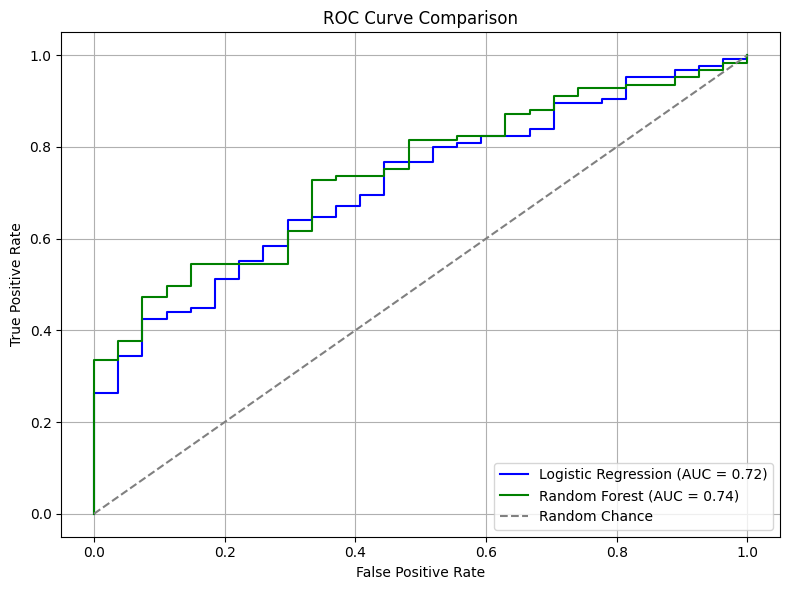

In [51]:
# Get predicted probabilities
y_proba_lr = logreg_pipeline.predict_proba(X_test)[:, 1]
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color='blue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Formatting
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### 9. Show Feature Importance

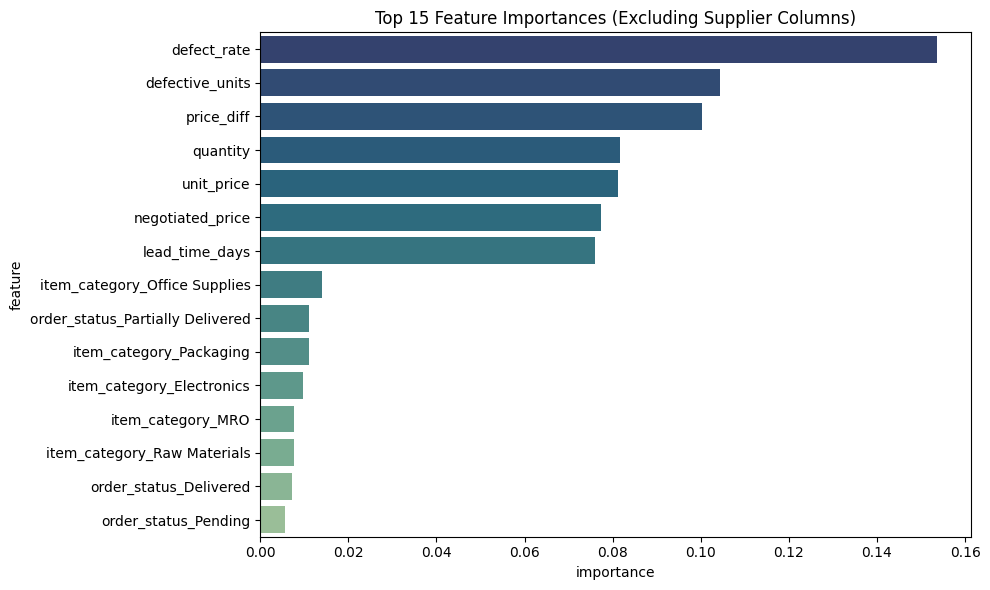

In [ ]:
# Extract trained classifier and preprocessor
best_pipeline = rf_grid.best_estimator_
classifier = best_pipeline.named_steps['classifier']
preprocessor = best_pipeline.named_steps['preprocessor']

# Get numeric feature names
numeric_features = numeric_cols

# Get categorical feature names from OneHotEncoder
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_features = ohe.get_feature_names_out(categorical_cols)

# Combine all feature names
all_features = list(numeric_features) + list(categorical_features)

# Get feature importances from Random Forest
importances = classifier.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
})

# Remove features that start with 'supplier'
importance_df = importance_df[~importance_df['feature'].str.startswith('supplier')]

# Sort and Plot
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', hue='feature', palette='crest_r', legend=False)
plt.title("Top 15 Feature Importances (Excluding Supplier Columns)")
plt.tight_layout()
plt.show()

****
### Reflection 1

| Model              | AUC Score | Interpretation                                                                 |
|--------------------|-----------|--------------------------------------------------------------------------------|
| Logistic Regression | 0.72      | Fair model performance. The model has a moderate ability to distinguish between classes.   |
| Random Forest       | 0.74      | Slightly better than logistic regression. Indicates a fair classification ability with improved separation between classes. |


The predictive modeling process did not confirm that procurement order compliance can be reliably forecasted using structured historical data. Both models achieved moderate performance across classification report metrics, but it needs to be able to predict non-compliant orders as well. The top indicators were: defect_rate, price_diff, and quantity. While both models struggle with the minority class, Random Forest edges out Logistic Regression due to its higher ROC AUC and more balanced recall, making it the better-performing model in this case. The next steps will try to achieve accurate classification of class 0 (compliance - No).
****
### 10. Top 3 Indicators Only (same models)

In [50]:
# Select subset of features
selected_features = ['defect_rate', 'price_diff', 'quantity']
X_sf = df[selected_features]
y_sf = df['compliance']

# Split the dataset
X_sf_train, X_sf_test, y_sf_train, y_sf_test = train_test_split(
    X_sf, y_sf, stratify=y_sf, test_size=0.2, random_state=42
)

# Build Logistic Regression pipeline
sf_logreg_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42,
    ))
])

# Train the model
sf_logreg_pipeline.fit(X_sf_train, y_sf_train)

# Predictions
y_pred_sf = sf_logreg_pipeline.predict(X_sf_test)
y_proba_sf = sf_logreg_pipeline.predict_proba(X_sf_test)[:, 1]

# Evaluation
print("=== Logistic Regression Classification Report ===")
print(classification_report(y_sf_test, y_pred_sf))
print("ROC AUC:", roc_auc_score(y_sf_test, y_proba_sf))

# Build Random Forest pipeline
sf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Set tuned parameters (based on previous GridSearchCV results)
sf_param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [5],
    'classifier__min_samples_split': [4]
}

# Grid search
sf_grid = GridSearchCV(sf_pipeline, sf_param_grid, cv=5, scoring='f1')
sf_grid.fit(X_sf_train, y_sf_train)

# Predictions
y_sf_pred = sf_grid.predict(X_sf_test)
y_sf_proba = sf_grid.predict_proba(X_sf_test)[:, 1]

# Evaluation
print("=== Random Forest Classification Report ===")
print(classification_report(y_sf_test, y_sf_pred))
print("ROC AUC:", roc_auc_score(y_sf_test, y_sf_proba))

# Best model for further use
sf_best_model = sf_grid.best_estimator_

=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.82      0.99      0.90       125

    accuracy                           0.82       152
   macro avg       0.41      0.50      0.45       152
weighted avg       0.68      0.82      0.74       152

ROC AUC: 0.5045925925925926
=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.82      0.98      0.89       125

    accuracy                           0.81       152
   macro avg       0.41      0.49      0.45       152
weighted avg       0.67      0.81      0.74       152

ROC AUC: 0.6702222222222223


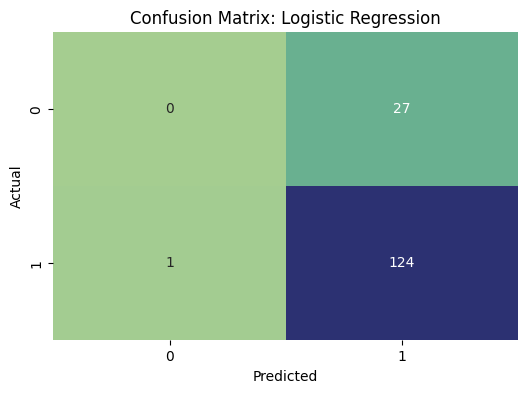

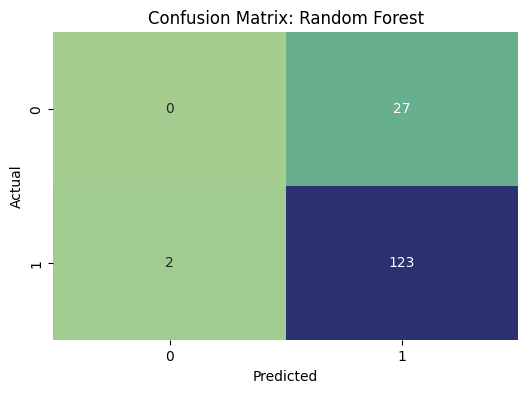

In [43]:
# --- Confusion Matrix for Logistic Regression ---
cm_logreg = confusion_matrix(y_sf_test, y_pred_sf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='crest', cbar=False)
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Confusion Matrix for Random Forest ---
cm_rf = confusion_matrix(y_sf_test, y_sf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='crest', cbar=False)
plt.title("Confusion Matrix: Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

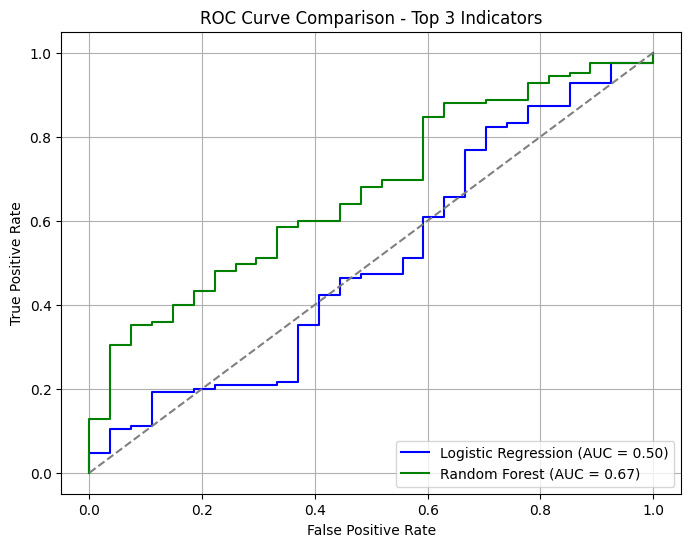

In [52]:
# --- ROC Curve Comparison ---
fpr_lr, tpr_lr, _ = roc_curve(y_sf_test, y_proba_sf)
fpr_rf, tpr_rf, _ = roc_curve(y_sf_test, y_sf_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_sf_test, y_proba_sf):.2f})", color='blue')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_sf_test, y_sf_proba):.2f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("ROC Curve Comparison - Top 3 Indicators")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Reflection 2
| Model              | AUC Score | Interpretation                                                                 |
|--------------------|-----------|--------------------------------------------------------------------------------|
| Logistic Regression (T3I) | 0.50      | Updated model now performs no better than random guessing in terms of probability ranking. (0.72 → 0.50)  |
| Random Forest (T3I)      | 0.67      | Modest decline in probability-based performance. (0.74 → 0.67) |

One reason that could explain the models performing worse when using only the top 3 indicating features could be that feature importances are usually derived from the training set. If the model has overfit, those importances may not reflect true generalization ability, and cutting features based on them can harm test performance. 
****

### Recommendations for Next Steps:

* Apply resampling techniques like SMOTE (Synthetic Minority Oversampling) for oversampling class 0.

* Use class weighting in both logistic regression and random forest (class_weight='balanced').

* Lower the probability threshold from 0.5 → 0.4 to improve recall/precision on class 0.

* Implement custom loss functions to penalize the model more heavily for missing the minority class. 